In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from src.data_utils import StyledMNISTGenerator, StyledMNIST
import src.corruptions as corruptions
from src.model import VAE
from src.trainer import VAETrainer, EarlyStopping, test_logging

%load_ext autoreload
%autoreload 2

In [3]:
mnist = MNIST("./data", train=True, download=False)

In [4]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:17<00:00, 3457.06item/s]


In [ ]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [ ]:
params = {
    "lr": 1e-4,
    "optimizer": "Adam",
    "batch_size": 128,
    "z_dim": 16,
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)


vae = VAE(params["z_dim"], nc=1).to("cuda")
trainer = VAETrainer(
    model=vae,
    optimizer=torch.optim.Adam(vae.parameters(), lr=params["lr"]),
    early_stopping=EarlyStopping(patience=5, model_signature=signature),
    verbose_period=1,
    device="cuda",
)

In [ ]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("resnet-test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=51, train_loader=train_loader, valid_loader=valid_loader)

In [ ]:
test_logging(
    trainer,
    test_loader,
    metric_names=["test_recontr_loss", "test_kl"],
    expr_name="resnet-test",
    run_name="dazzling-cat-152",
)


val-epoch 0: 100%|██████████| 79/79 [00:01<00:00, 44.68it/s]

val_recontr_loss=26.845, val_kl=8.691
Successfully added metrics to run 5916f01c31e94b9985007d49cb0d9a4c


In [36]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

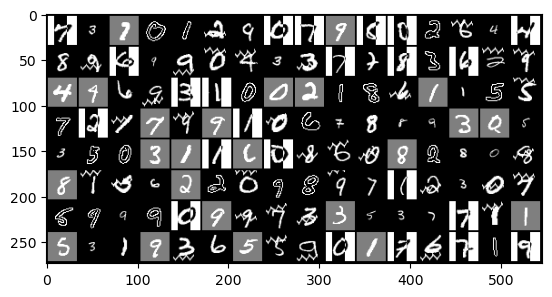

In [49]:
x = next(iter(test_loader))[0].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

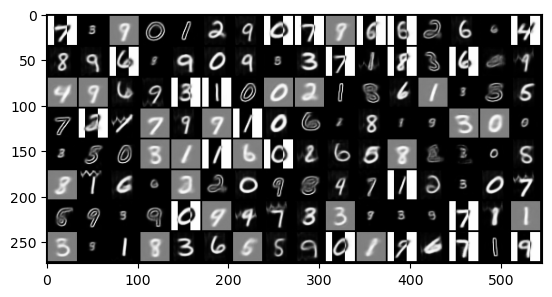

In [ ]:
best_model = mlflow.pytorch.load_model('runs:/8bd8d99eae684e05b416292aad162b59/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, _, z = best_model(x, explicit=True)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

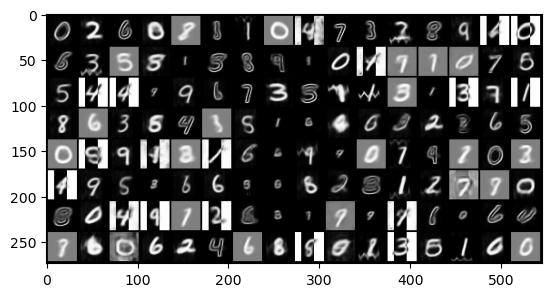

In [52]:
with torch.no_grad():
    best_model.eval()
    z = torch.randn(128, 16).to("cuda")
    x = best_model.decoder(z)
    plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))